# 1. Подготовка данных

In [1]:
import warnings

# Игнорирование FutureWarning и UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# DATASET = r'dataset\\Первичная выгрузка Станки Загрузка по дням.xlsx'
DATASET = r'dataset\\signal_data_full.xlsx'

In [4]:
df = pd.read_excel(DATASET)

In [ ]:
# df.drop(df.tail(1).index,inplace=True, errors='ignore')
# df.drop(['Объект'], axis=1, inplace=True, errors='ignore')

In [ ]:
 # drop last n rows
# df.drop(columns=['Качество', 'Станок под нагрузкой', 'OEE'], inplace=True)

In [5]:
df.fillna(0, inplace=True)

In [6]:
df.drop(columns=['Объект'], inplace=True)

In [7]:
# df = df[df["Дата"] >= "2023-01-01"].reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93609 entries, 0 to 93608
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Дата                        93609 non-null  object 
 1   M00 останов                 93609 non-null  float64
 2   M01 останов                 93609 non-null  float64
 3   Аварийная остановка         93609 non-null  float64
 4   Авария                      93609 non-null  float64
 5   Блокировка подачи           93609 non-null  float64
 6   Контроль ОТК                93609 non-null  float64
 7   Наладка                     93609 non-null  float64
 8   Отработка программы         93609 non-null  float64
 9   Отсутствие заготовки        93609 non-null  float64
 10  Отсутствие инструмента      93609 non-null  float64
 11  Отсутствие КД/модели        93609 non-null  float64
 12  Отсутствие программы        93609 non-null  float64
 13  Перерыв                     936

In [9]:
df['Дата'] = pd.to_datetime(df['Дата']).dt.normalize()

In [10]:
df.set_index('Дата', inplace=True)

In [11]:
df_agg = df.groupby('Дата').sum()

In [12]:
df_agg["ВП"] = df_agg["Серийное производство"] + df_agg["Программа выполняется"]
df_agg["ВРО"] = df_agg["ВП"] + df_agg["Прогрев станка"] + df_agg["Отработка программы"] + df_agg["Ручной режим"] + df_agg["Станок включен"]

df_agg["ВРП"] = df_agg["ВРО"] + df_agg["Наладка"] + df_agg["Контроль ОТК"]+ df_agg["Регламентированный перерыв"]+ df_agg["Уборка оборудования"]+ df_agg["Сервисное обслуживание"]+ df_agg["Отсутствие заготовки"]+ df_agg["Отсутствие программы"]+ df_agg["Отсутствие инструмента"]+ df_agg["Отсутствие КД/модели"]+ df_agg["Ремонтные работы"]+ df_agg["Авария"]+ df_agg["Аварийная остановка"]

df_agg["OEE"] = df_agg["ВРО"] / df_agg["ВРП"] * df_agg["ВП"] / df_agg["ВРО"] * 0.95

In [13]:
exclude_columns = ["Производительность", "Доступность", "ВРО", "ВРП", "ВП"]
df_agg.drop(exclude_columns, axis=1, inplace=True, errors="ignore")

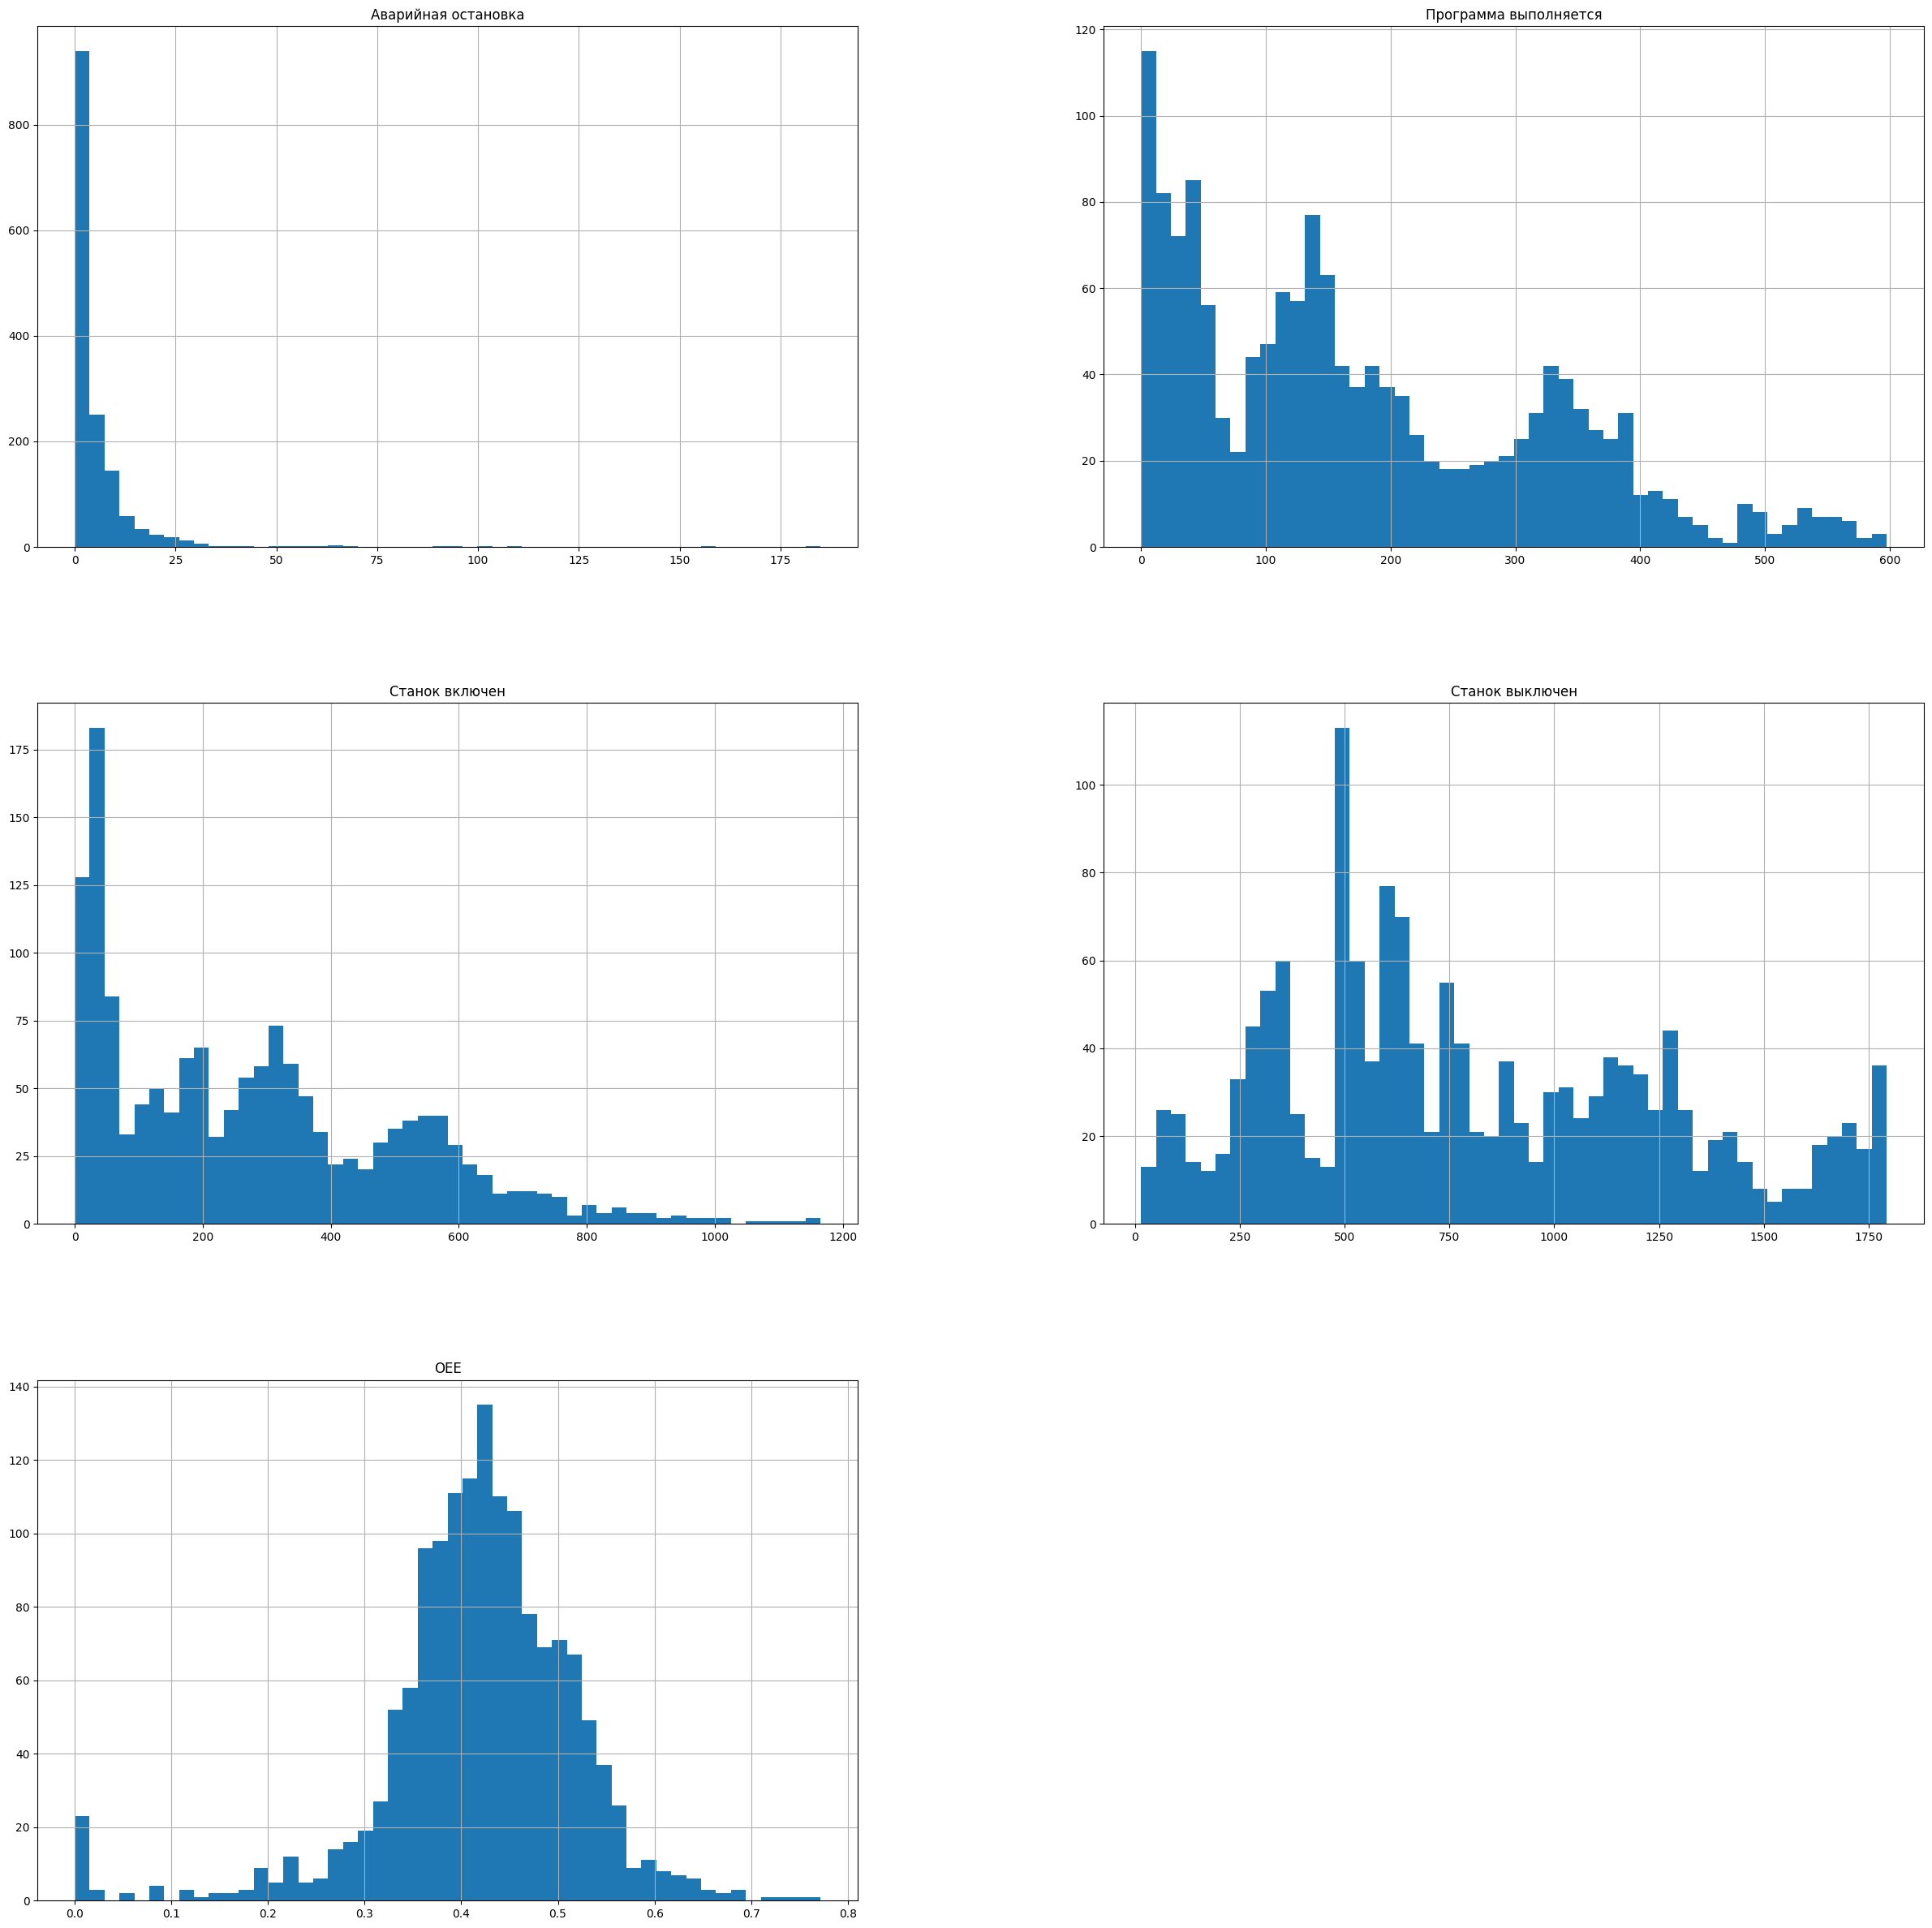

In [14]:
# Рассчитываем порог для NaN и 0
threshold = len(df_agg) * 0.2

# Удаляем столбцы, где количество NaN или 0 больше 50%
columns_0_more_20_per = [
    col
    for col in df_agg.columns
    if df_agg[col].isna().sum() > threshold or (df_agg[col] == 0).sum() > threshold
]

df_cleaned = df_agg.drop(columns=columns_0_more_20_per)

# Теперь df_cleaned содержит только те столбцы, где количество NaN и 0 не превышает 50%
df_cleaned.hist(bins=50, figsize=(30, 30));

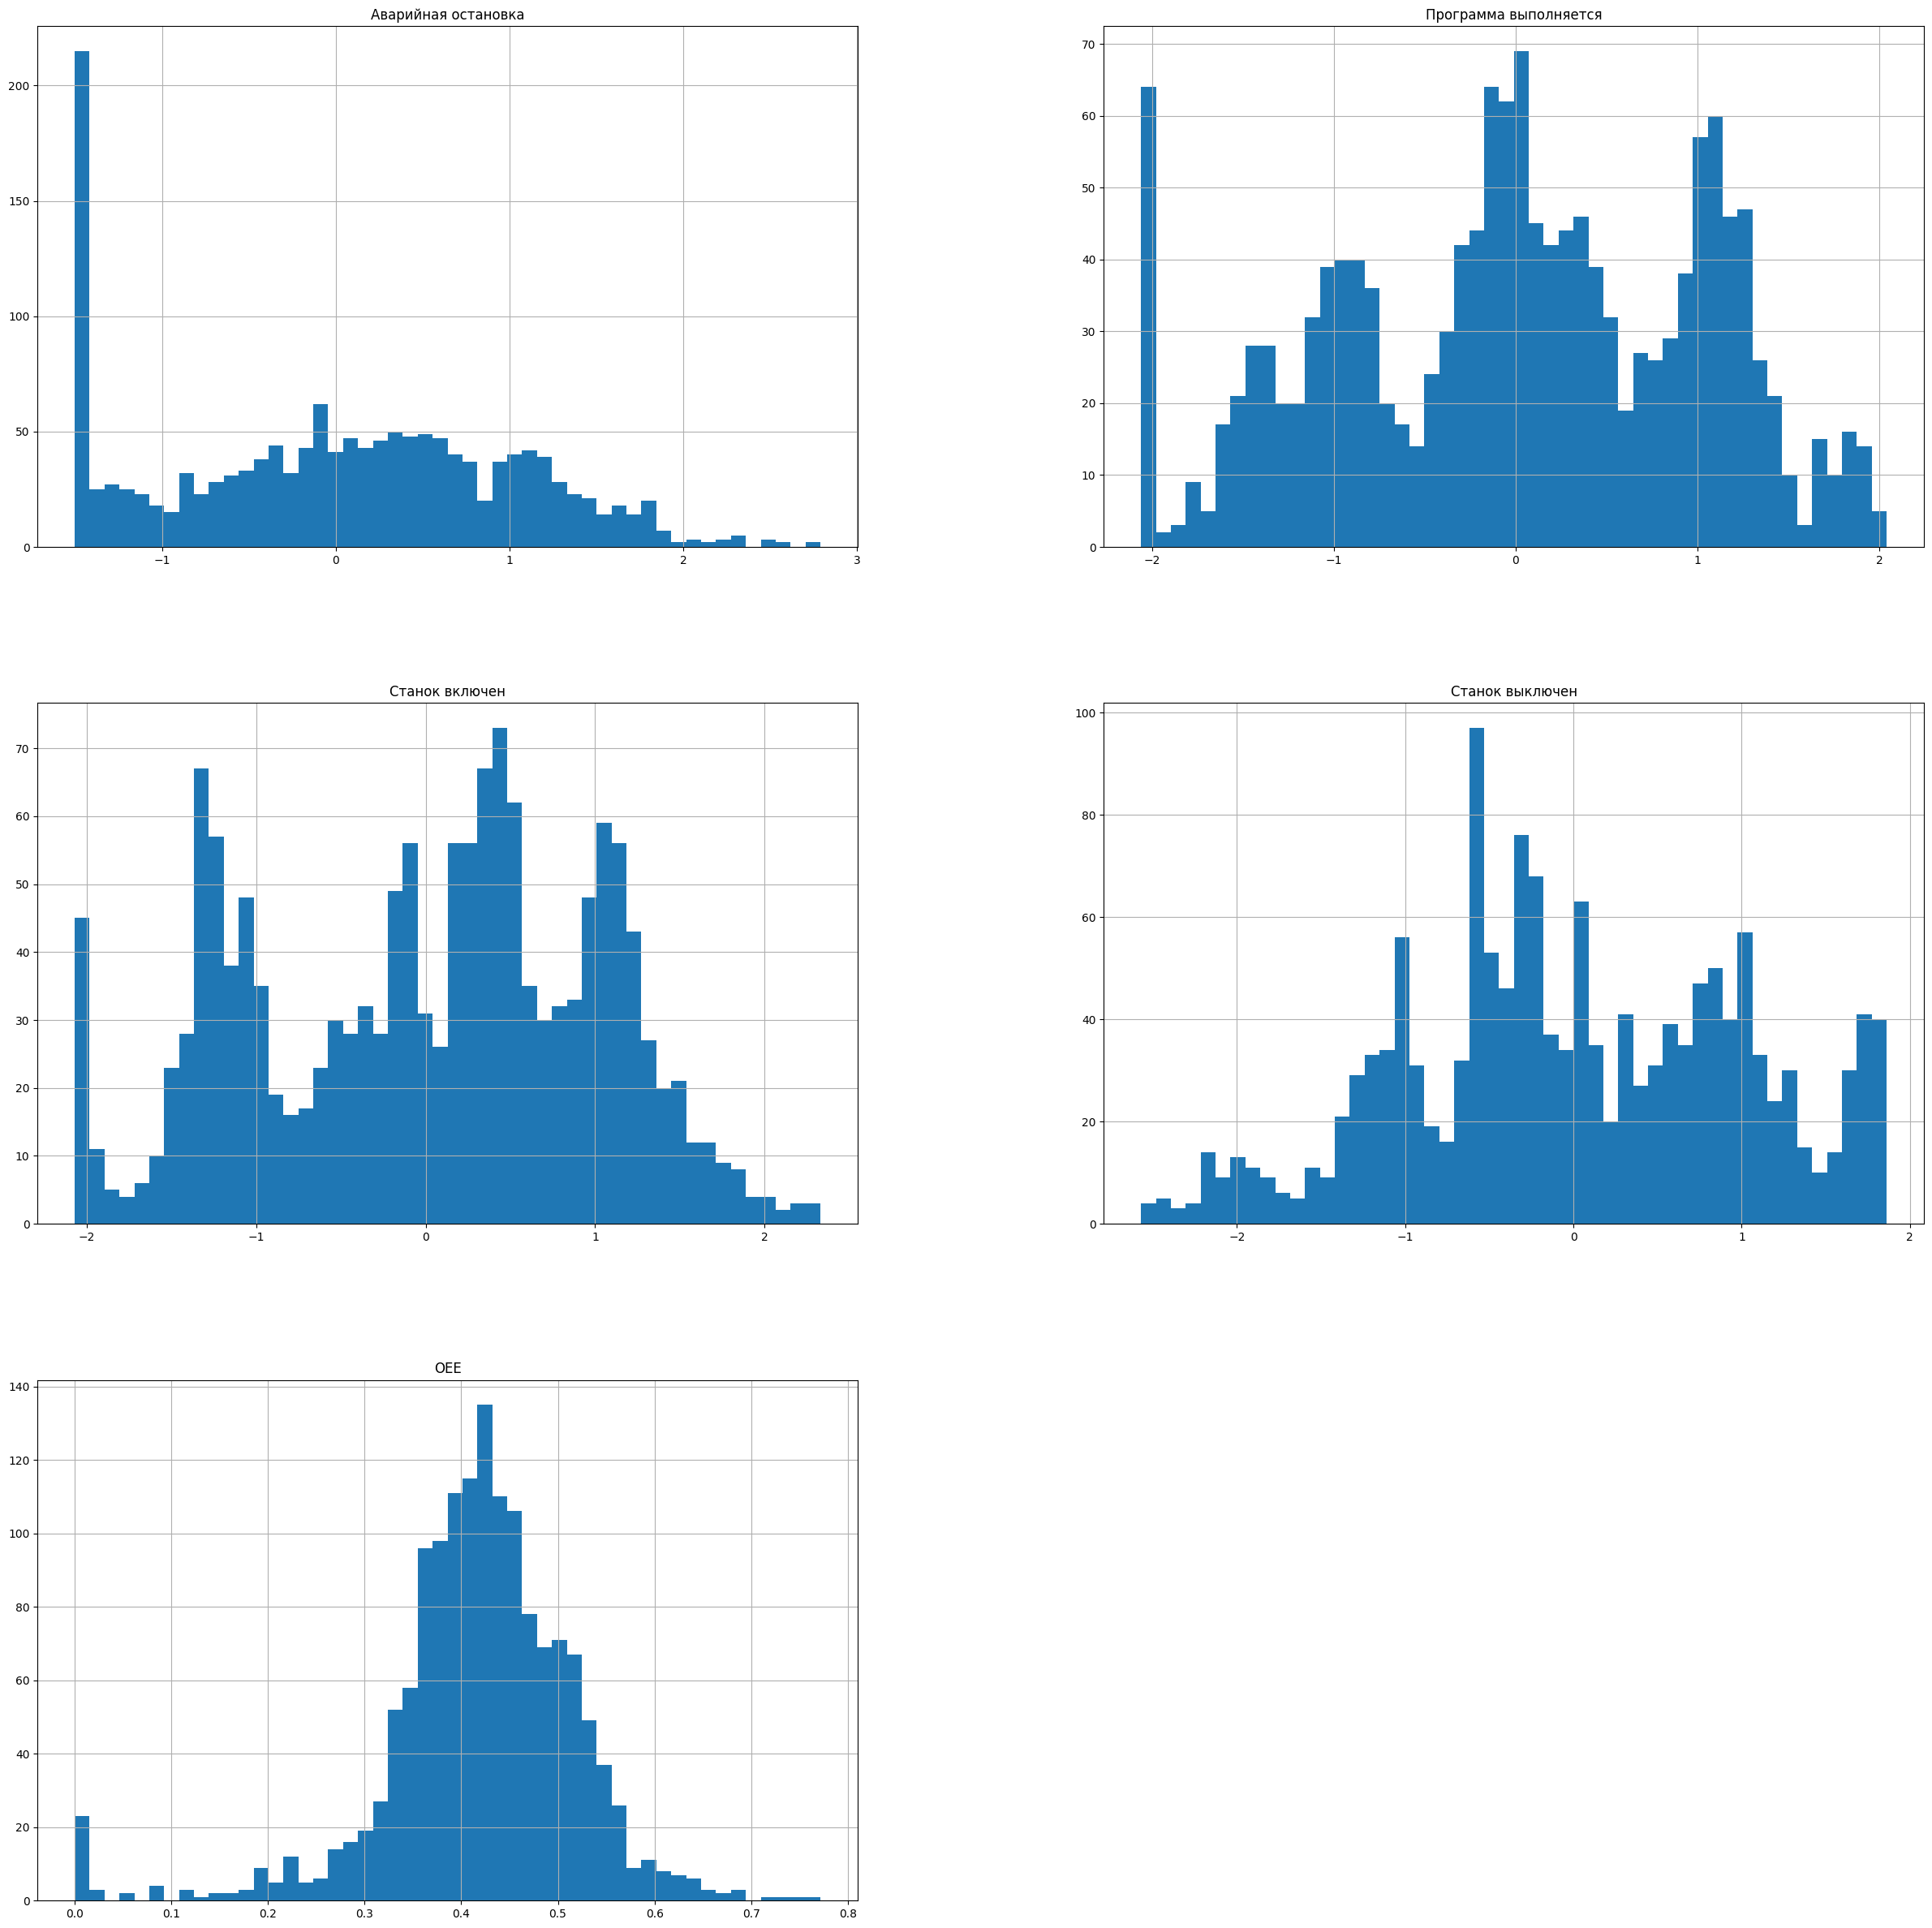

In [15]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
df_cleaned[df_cleaned.drop(["OEE"], axis=1).columns] = pt.fit_transform(df_cleaned.drop(["OEE"], axis=1))

df_cleaned.hist(bins=50, figsize=(30, 30));

# 2. Исследовательский анализ

In [16]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

def decompose_df(df, column_names, model='additive', period=30):
    for col in column_names:
        series = df[col].dropna()
        decompose_result = seasonal_decompose(series, model=model, period=period)

        fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        components = [("Observed", series, "black"),
                      ("Trend", decompose_result.trend, "blue"),
                      ("Seasonality", decompose_result.seasonal, "green"),
                      ("Residuals", decompose_result.resid, "red")]

        for i, (label, data, color) in enumerate(components):
            axes[i].plot(data, label=label, color=color)
            axes[i].legend()
            axes[i].set_ylabel(label)
            axes[i].grid(True)

        plt.suptitle(f"Сезонная декомпозиция временного ряда '{col}'", fontsize=16)
        plt.show()
        
def decompose_df_stl(df, column_names, seasonal=13, robust=False):
    for col in column_names:
        series = df[col].dropna()
        stl = STL(series, seasonal=seasonal, robust=robust)
        decompose_result = stl.fit()

        fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        components = [("Observed", series, "black"),
                      ("Trend", decompose_result.trend, "blue"),
                      ("Seasonality", decompose_result.seasonal, "green"),
                      ("Residuals", decompose_result.resid, "red")]

        for i, (label, data, color) in enumerate(components):
            axes[i].plot(data, label=label, color=color)
            axes[i].legend()
            axes[i].set_ylabel(label)
            axes[i].grid(True)

        plt.suptitle(f"STL-декомпозиция временного ряда '{col}'", fontsize=16)
        plt.show()

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def built_acf_and_pacf(df, column_names):

    for col in column_names:
        series = df[col].dropna()  # Берем только один столбец и удаляем NaN

        # Строим ACF и PACF
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        plot_acf(series, lags=30, ax=axes[0])  # ACF для выбора q
        axes[0].set_title("ACF - Автокорреляция")

        plot_pacf(series, lags=30, ax=axes[1])  # PACF для выбора p
        axes[1].set_title("PACF - Частичная автокорреляция")

        # Добавляем общий заголовок
        fig.suptitle(f"ACF и PACF для '{col}'", fontsize=14)

        plt.show()  # Отображаем графики

In [18]:
#Выбираем целевые переменные
target_columns = ["OEE"]

## Визуализация графика

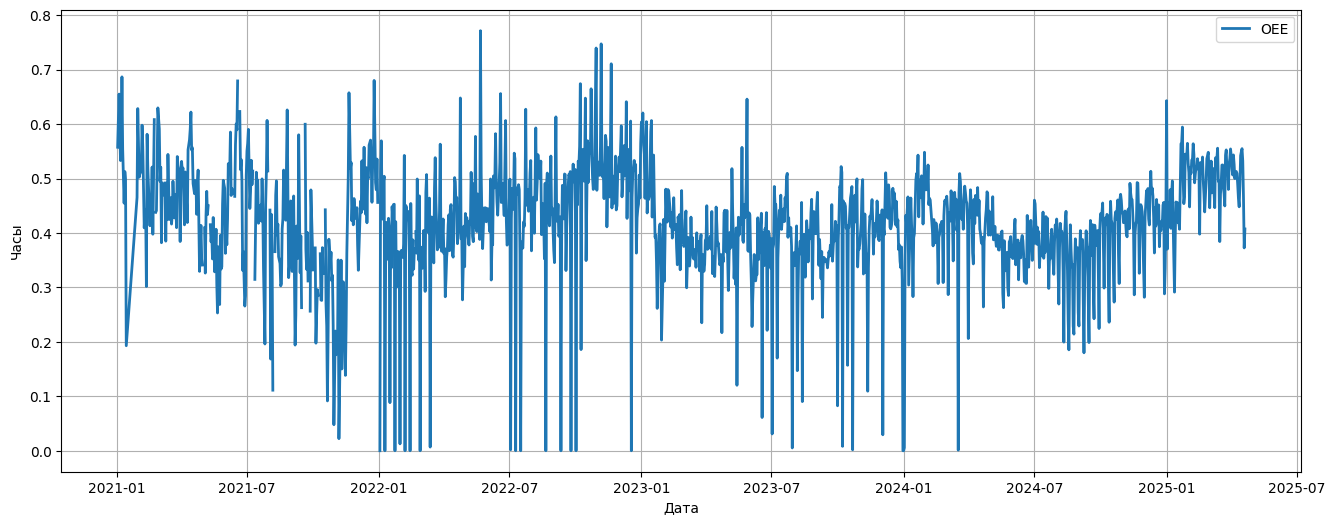

In [19]:
# Строим график временного ряда
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(df_cleaned.index, df_cleaned['OEE'], label="OEE", linewidth=2)
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.legend()
plt.grid(True)
plt.show()

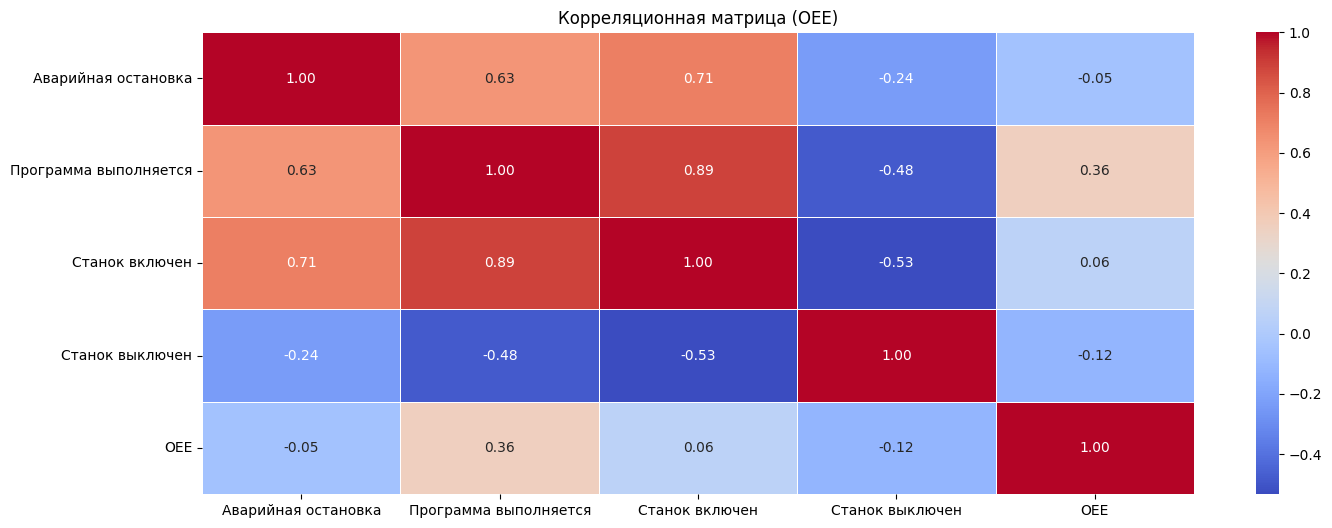

{'OEE': ['Программа выполняется']}

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Вычисление корреляции между целевыми и экзогенными переменными

# correlation_matrix_oee = df_cleaned[["OEE"] + df_cleaned.columns.drop(["OEE"]).to_list()].corr()

# df_cleaned.drop(labels=exclude_columns, axis=1, errors="ignore", inplace=True)
correlation_matrix_oee = df_cleaned.corr()

# Определение экзогенных переменных (корреляция > 0.2)

exog_vars_oee = correlation_matrix_oee["OEE"].drop("OEE").abs()

exog_columns_oee = exog_vars_oee[exog_vars_oee > 0.3].index.tolist()
# top_n = 10  # Количество переменных
# exog_columns_oee = exog_vars_oee.sort_values(ascending=False).head(top_n).index.tolist()

# Визуализация корреляционной матрицы для "OEE"
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_matrix_oee, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица (OEE)")
plt.show()

# Создание словаря с экзогенными переменными
exog_variables_dict = {
    "OEE": exog_columns_oee
}

# Вывод словаря
exog_variables_dict

In [23]:
non_exog_columns = df_cleaned.columns.drop(exog_variables_dict['OEE']).to_list()
non_exog_columns.remove('OEE')
non_exog_columns

['Аварийная остановка', 'Станок включен', 'Станок выключен']

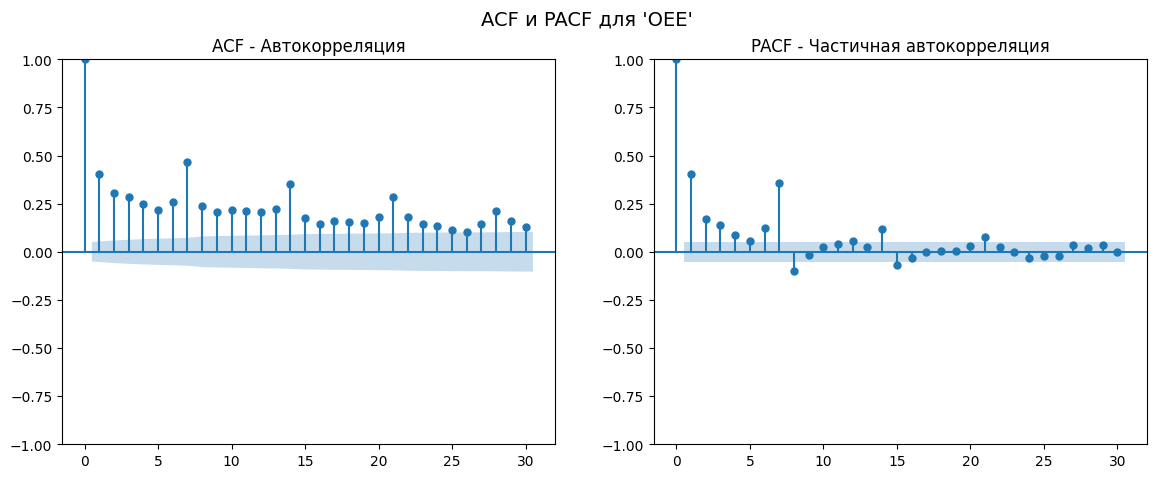

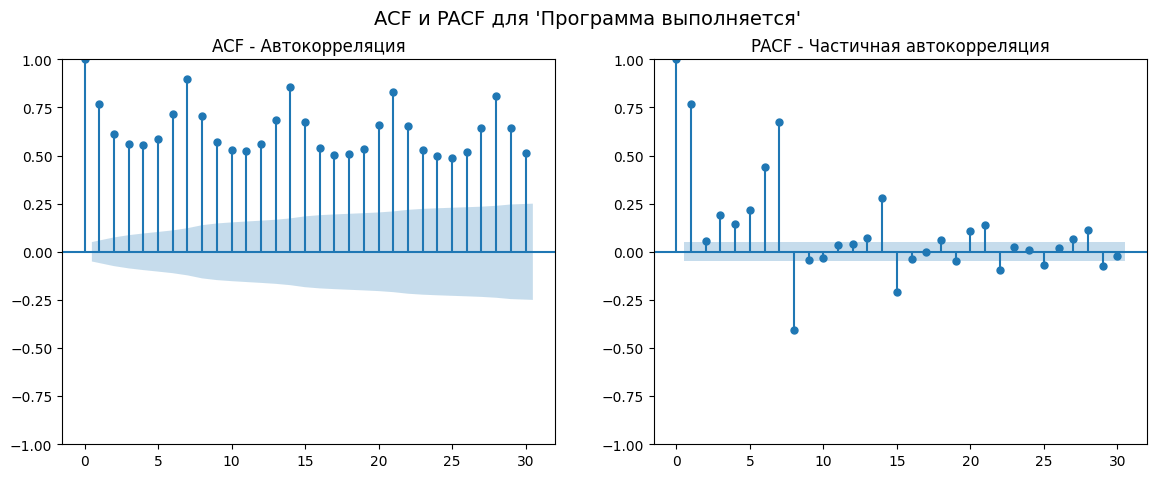

In [24]:
built_acf_and_pacf(df_cleaned, target_columns)
built_acf_and_pacf(df_cleaned, exog_variables_dict['OEE'])

In [25]:
import holidays

In [26]:
def preprocess_data(data, target, exog_columns=None, lag_start=1, lag_end=7, test_size=0.2):
    data = pd.DataFrame(data.copy())

    # --- Создаем лаги для целевой переменной ---
    for i in range(lag_start, lag_end+1):
        data[f"lag_{i}"] = data[target].shift(i)

    # --- Создаем лаги для экзогенных переменных ---
    if exog_columns is not None:
        for col in exog_columns:
            for i in range(lag_start, lag_end+1):
                data[f'{col}_lag_{i}'] = data[col].shift(i)
    else:
        for col in data.drop(target, axis=1).columns.to_list():
            for i in range(lag_start, lag_end+1):
                data[f'{col}_lag_{i}'] = data[col].shift(i)
    

    data = data.dropna()

    # --- Добавляем временные признаки ---
    data["day_of_week"] = data.index.dayofweek
    data["month"] = data.index.month
    data["date"] = data.index.day.astype(int)  # Числовой формат
    
    # --- Добавляем колонку "holiday" ---
    ru_holidays = holidays.RU(years=data.index.year.unique())  # Автоматический поиск праздников
    data["holiday"] = data.index.map(lambda x: 1 if x in ru_holidays else 0)

    # --- Добавляем скользящее среднее ---
    data["rolling_mean_7"] = data[target].rolling(7).mean()
    data["rolling_mean_14"] = data[target].rolling(14).mean()
    data["rolling_mean_30"] = data[target].rolling(30).mean()

    # --- Удаляем NaN после добавления лагов и скользящих средних ---
    data.dropna(inplace=True)

    # --- Рассчитываем средние по времени ---
    size = int(len(data) * (1 - test_size))

    date_means = data.groupby('date')[target].mean()

    data['date_average'] = data['date'].map(date_means)

    # --- Удаляем лишние колонки ---
    
    # --- Разделение на train/test ---
    X_train = data.iloc[:size].drop(target, axis=1)
    X_test = data.iloc[size:].drop(target, axis=1)
    y_train = data[target].iloc[:size]
    y_test = data[target].iloc[size:]

    return X_train, X_test, y_train, y_test


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

In [28]:
# custom_lags = [1, 2, 3, 4, 5, 6, 7, 14, 30]
TEST_SIZE = 0.2
LAG = 60
# X_train, X_test, y_train, y_test = preprocess_data(df_cleaned, target='OEE', lag_end=LAG, exog_columns=exog_variables_dict['OEE'], test_size=TEST_SIZE)
X_train, X_test, y_train, y_test = preprocess_data(df_cleaned, target='OEE', lag_end=LAG, exog_columns=None, test_size=TEST_SIZE)

C:\Users\admin\AppData\Local\Temp\ipykernel_20068\1735738370.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_lag_{i}'] = data[col].shift(i)
C:\Users\admin\AppData\Local\Temp\ipykernel_20068\1735738370.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_lag_{i}'] = data[col].shift(i)
C:\Users\admin\AppData\Local\Temp\ipykernel_20068\1735738370.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# --- Фиксируем seed для воспроизводимости ---
RANDOM_SEED = 42

# --- Параметры кросс-валидации (5 фолдов для временных рядов) ---
tscv = TimeSeriesSplit(n_splits=5)

# --- Список моделей и их параметров для подбора ---
models = {
    # "LinearRegression": {
    #     "pipeline": Pipeline([
    #         ("scaler", StandardScaler()),
    #         ("model", LinearRegression())
    #     ]),
    #     "params": {}  # У линейной регрессии нет гиперпараметров
    # },
    # "DecisionTreeRegressor": {
    #     "pipeline": Pipeline([
    #         ("scaler", StandardScaler()),
    #         ("model", DecisionTreeRegressor(random_state=RANDOM_SEED))
    #     ]),
    #     "params": {
    #         "model__max_depth": [3, 5, 10, 20],
    #         "model__min_samples_split": [2, 5, 10],
    #         "model__min_samples_leaf": [1, 2, 4]
    #     }
    # },
    # "RandomForestRegressor": {
    #     "pipeline": Pipeline([
    #         ("scaler", StandardScaler()),
    #         ("model", RandomForestRegressor(random_state=RANDOM_SEED))
    #     ]),
    #     "params": {
    #         "model__n_estimators": [50, 100, 150, 200],
    #         "model__max_depth": [5, 7, 9, 11],
    #         "model__min_samples_split": [2, 4, 6, 8],
    #         "model__min_samples_leaf": [1, 2, 3, 4]
    #     }
    # },
    "CatBoostRegressor": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", CatBoostRegressor(verbose=2, random_seed=RANDOM_SEED, has_time=True))
        ]),
        "params": {
            "model__depth": [4, 6],
            "model__iterations": [200],
            "model__learning_rate": [0.03, 0.05],
            "model__l2_leaf_reg": [3, 5, 7]
        }
    },
    # "SVR": {
    #     "pipeline": Pipeline([
    #         ("scaler", StandardScaler()),  # Нормализация данных перед SVM
    #         ("model", SVR())
    #     ]),
    #     "params": {
    #         "model__kernel": ["linear", "rbf"],
    #         "model__C": [0.1, 1, 10],
    #         "model__epsilon": [0.01, 0.1, 1]
    #     }
    # }
}

# --- Хранение результатов ---
results = []

# --- Обучение и подбор гиперпараметров ---
for model_name, model_info in models.items():
    print(f"🔹 Обучаем модель: {model_name}")

    # RandomizedSearchCV для подбора гиперпараметров (быстрее, чем GridSearchCV)
    search = RandomizedSearchCV(
        model_info["pipeline"],
        model_info["params"],
        n_iter=10,  # Количество случайных комбинаций параметров
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        random_state=RANDOM_SEED,  # Фиксируем seed
        verbose=2,
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # --- Предсказания на тесте ---
    preds = best_model.predict(X_test)

    # --- Оценка метрик ---
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "model": model_name,
        "best_params": search.best_params_,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
    })

# --- Вывод результатов ---
df_results = pd.DataFrame(results).sort_values(by="MAE")
display(df_results)

# --- Вывод лучших параметров для каждой модели ---
for i in df_results['best_params']:
    print(i)

🔹 Обучаем модель: CatBoostRegressor
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.0954201	total: 221ms	remaining: 44.1s
2:	learn: 0.0923869	total: 346ms	remaining: 22.7s
4:	learn: 0.0892785	total: 479ms	remaining: 18.7s
6:	learn: 0.0861762	total: 605ms	remaining: 16.7s
8:	learn: 0.0835214	total: 721ms	remaining: 15.3s
10:	learn: 0.0809015	total: 842ms	remaining: 14.5s
12:	learn: 0.0787879	total: 961ms	remaining: 13.8s
14:	learn: 0.0767029	total: 1.08s	remaining: 13.3s
16:	learn: 0.0748016	total: 1.2s	remaining: 12.9s
18:	learn: 0.0730905	total: 1.34s	remaining: 12.7s
20:	learn: 0.0715184	total: 1.47s	remaining: 12.5s
22:	learn: 0.0697143	total: 1.59s	remaining: 12.2s
24:	learn: 0.0681272	total: 1.71s	remaining: 12s
26:	learn: 0.0667065	total: 1.83s	remaining: 11.7s
28:	learn: 0.0656108	total: 1.95s	remaining: 11.5s
30:	learn: 0.0642957	total: 2.08s	remaining: 11.3s
32:	learn: 0.0628648	total: 2.2s	remaining: 11.1s
34:	learn: 0.0617197	total: 2.32s	remaining: 

,model,best_params,MAE,MSE,RMSE,MAPE,R2
0,CatBoostRegressor,"{'model__learning_rate': 0.05, 'model__l2_leaf...",0.030956,0.001569,0.039613,0.068608,0.646095


{'model__learning_rate': 0.05, 'model__l2_leaf_reg': 7, 'model__iterations': 200, 'model__depth': 4}


In [47]:
rf_params = next(item["best_params"] for item in results if item["model"] == "CatBoostRegressor")
print(rf_params)

{'model__learning_rate': 0.05, 'model__l2_leaf_reg': 7, 'model__iterations': 200, 'model__depth': 4}


0:	learn: 0.0961743	total: 89.4ms	remaining: 17.8s
1:	learn: 0.0942902	total: 149ms	remaining: 14.8s
2:	learn: 0.0927398	total: 211ms	remaining: 13.9s
3:	learn: 0.0912109	total: 275ms	remaining: 13.5s
4:	learn: 0.0895035	total: 337ms	remaining: 13.1s
5:	learn: 0.0882250	total: 397ms	remaining: 12.8s
6:	learn: 0.0869971	total: 458ms	remaining: 12.6s
7:	learn: 0.0856244	total: 519ms	remaining: 12.4s
8:	learn: 0.0840243	total: 586ms	remaining: 12.4s
9:	learn: 0.0828257	total: 647ms	remaining: 12.3s
10:	learn: 0.0814565	total: 706ms	remaining: 12.1s
11:	learn: 0.0801783	total: 769ms	remaining: 12s
12:	learn: 0.0788986	total: 829ms	remaining: 11.9s
13:	learn: 0.0777198	total: 895ms	remaining: 11.9s
14:	learn: 0.0768252	total: 955ms	remaining: 11.8s
15:	learn: 0.0755521	total: 1.01s	remaining: 11.7s
16:	learn: 0.0746505	total: 1.08s	remaining: 11.6s
17:	learn: 0.0739252	total: 1.14s	remaining: 11.5s
18:	learn: 0.0727840	total: 1.2s	remaining: 11.4s
19:	learn: 0.0720695	total: 1.25s	remaining

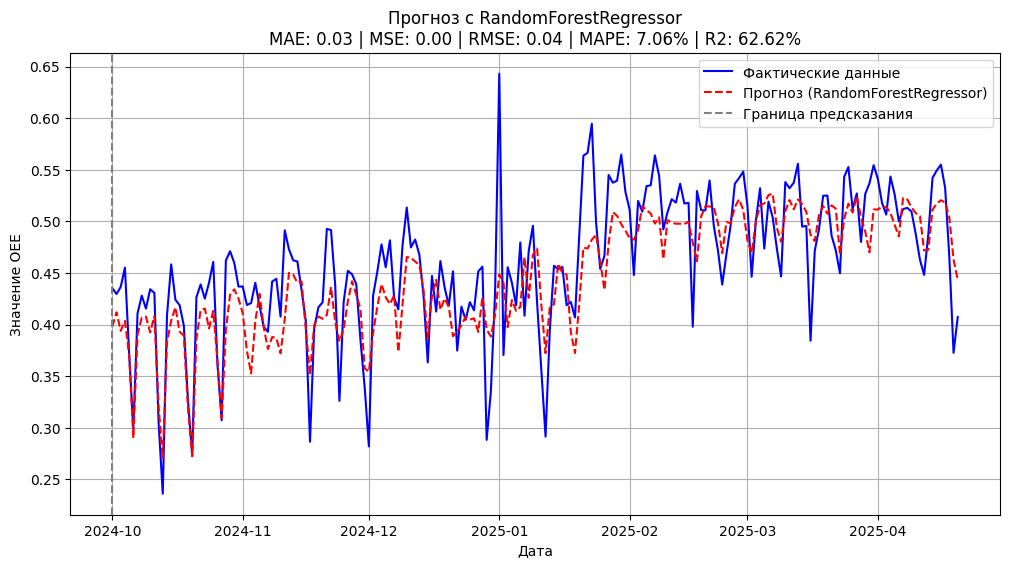

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# --- Убираем префикс "model__" из rf_params ---
cleaned_rf_params = {k.replace("model__", ""): v for k, v in rf_params.items()}

# --- Обучение модели с лучшими параметрами через Pipeline ---
best_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", CatBoostRegressor(**cleaned_rf_params))
])

best_pipeline.fit(X_train, y_train)  # Обучаем

# --- Прогнозирование ---
final_preds = best_pipeline.predict(X_test)

# --- Вычисление метрик ---
mae = mean_absolute_error(y_test, final_preds)
mse = mean_squared_error(y_test, final_preds)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)

# --- Визуализация прогноза ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Фактические данные", color="blue")
plt.plot(y_test.index, final_preds, label="Прогноз (RandomForestRegressor)", color="red", linestyle="dashed")

plt.axvline(x=y_test.index[0], color="gray", linestyle="--", label="Граница предсказания")
plt.legend()
plt.title(f"Прогноз с RandomForestRegressor\n"
          f"MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2%} | R2: {r2:.2%}")
plt.xlabel("Дата")
plt.ylabel("Значение OEE")
plt.grid(True)
plt.show()


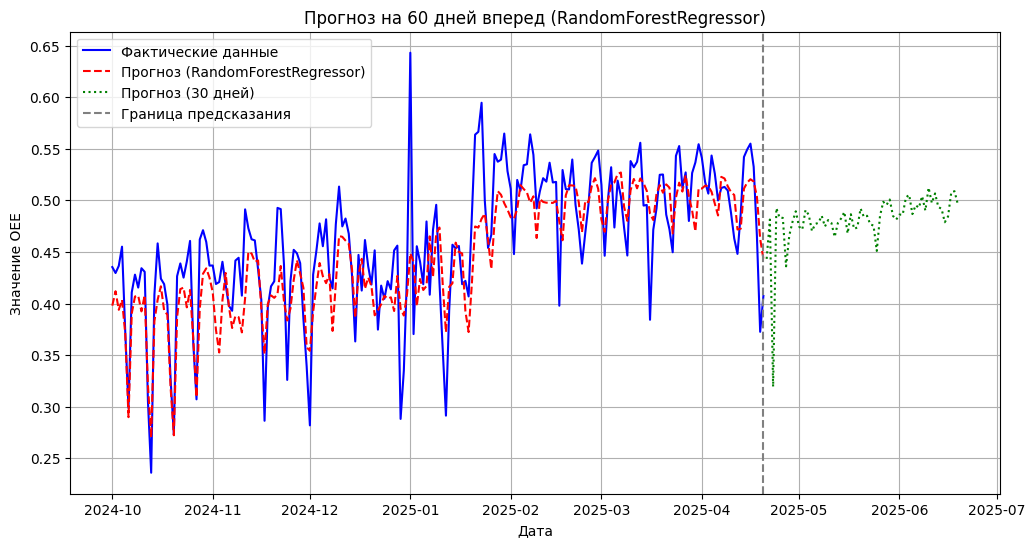

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# --- Итеративный прогноз на 30 дней вперед ---
forecast_horizon = 60
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq="D")

# Копируем последнюю строку X_test как основу для прогнозирования
last_known_data = X_test.iloc[-1:].copy()
future_preds = []

for _ in range(forecast_horizon):
    next_pred = best_pipeline.predict(last_known_data)[0]  # Прогноз следующего дня
    future_preds.append(next_pred)
    
    # Сдвигаем лаги: удаляем самый старый лаг и добавляем новое предсказанное значение
    last_known_data = last_known_data.shift(-1, axis=1)  # Сдвиг всех лагов
    last_known_data.iloc[:, -1] = next_pred  # Добавляем новый прогноз в самый свежий лаг

# --- Визуализация прогноза ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Фактические данные", color="blue")
plt.plot(y_test.index, final_preds, label="Прогноз (RandomForestRegressor)", color="red", linestyle="dashed")
plt.plot(future_dates, future_preds, label="Прогноз (30 дней)", color="green", linestyle="dotted")

plt.axvline(x=y_test.index[-1], color="gray", linestyle="--", label="Граница предсказания")
plt.legend()
plt.title("Прогноз на 60 дней вперед (RandomForestRegressor)")
plt.xlabel("Дата")
plt.ylabel("Значение OEE")
plt.grid(True)
plt.show()


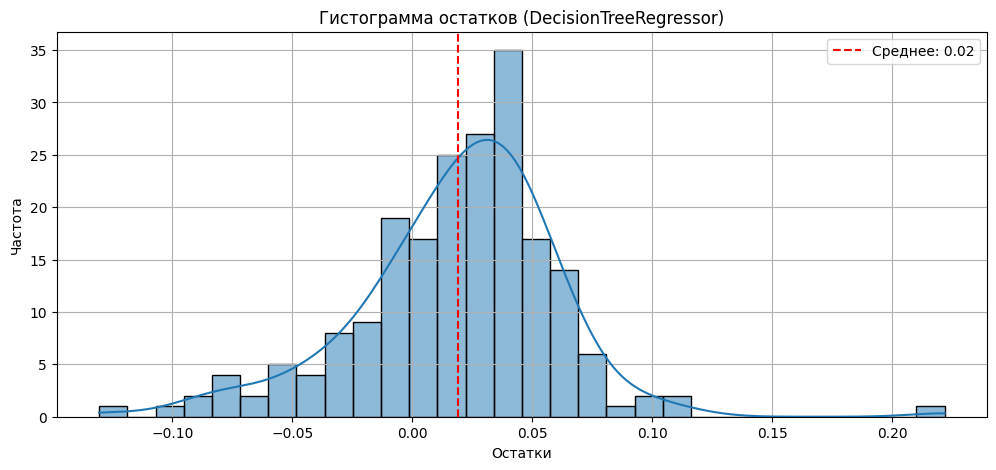

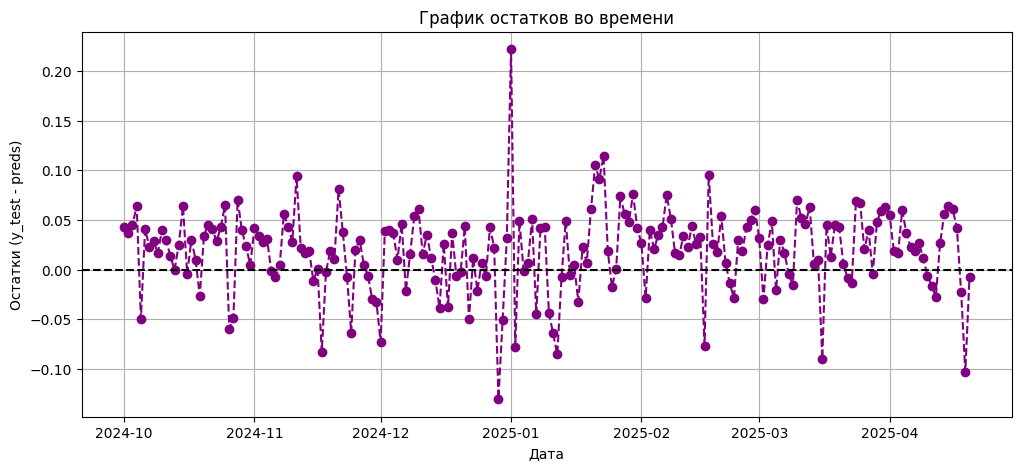

<Figure size 1200x500 with 0 Axes>

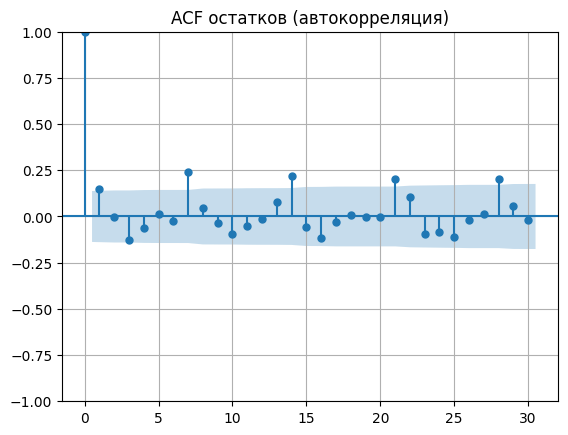

In [34]:
# --- Анализ остатков ---
residuals = y_test - final_preds

# --- Гистограмма остатков ---
plt.figure(figsize=(12, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(residuals.mean(), color="red", linestyle="dashed", label=f"Среднее: {residuals.mean():.2f}")
plt.legend()
plt.title("Гистограмма остатков (DecisionTreeRegressor)")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

# --- График остатков во времени ---
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, residuals, marker="o", linestyle="dashed", color="purple")
plt.axhline(0, color="black", linestyle="--")
plt.title("График остатков во времени")
plt.xlabel("Дата")
plt.ylabel("Остатки (y_test - preds)")
plt.grid(True)
plt.show()

# --- ACF остатков (автокорреляция) ---
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 5))
plot_acf(residuals, lags=30)
plt.title("ACF остатков (автокорреляция)")
plt.grid(True)
plt.show()
